## Network Characterization

In [547]:
'''
Created on 2023-10-25 12:51:32
@author: caitgrasso
'''

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from collections import Counter
from scipy.stats import linregress
import os
from matplotlib.patches import Patch

### Load data

In [548]:
BOT = 'bot_04'

# Load FC matrices
fc_before = np.loadtxt('../network_inference_data/fc_matrices/{}_before_mimat_w.csv'.format(BOT), delimiter=',')
fc_after = np.loadtxt('../network_inference_data/fc_matrices/{}_after_mimat_w.csv'.format(BOT), delimiter=',')

# Load spatial data
com_df_before = pd.read_csv('../spatial_data/raw_spatial/{}_before_centroids.csv'.format(BOT), header=0)
com_df_after = pd.read_csv('../spatial_data/raw_spatial/{}_after_centroids.csv'.format(BOT), header=0)

pixels_df_before = pd.read_csv('../spatial_data/raw_spatial/{}_before_pixels.csv'.format(BOT), header=0)
pixels_df_after = pd.read_csv('../spatial_data/raw_spatial/{}_after_pixels.csv'.format(BOT), header=0)

# Load  bot images
img_before = cv2.imread(f'../bot_images/{BOT}_before_00001.tiff')
img_after = cv2.imread(f'../bot_images/{BOT}_after_00001.tiff')

os.makedirs('../results/', exist_ok=True)
os.makedirs('../results/network_characterization_plots/',exist_ok=True)
os.makedirs(f'../results/network_characterization_plots/{BOT}/', exist_ok=True)

In [549]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif'})

### Segmentation of nodes included in the network

Before

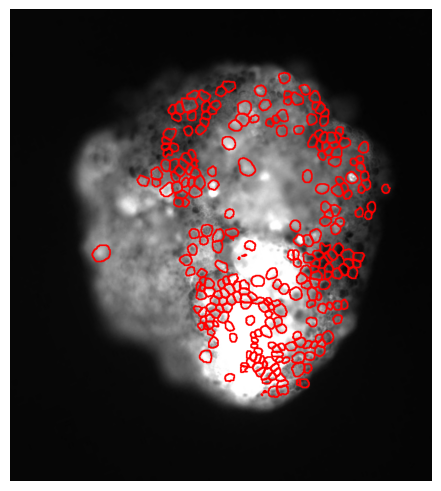

In [550]:
labels = np.unique(pixels_df_before['label'])

# Draw contours

# Note: (0,0) in OpenCV is top left. (0,0) in matplotlib is bottom left

contour_img = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)

for i in labels:
    xs = list(pixels_df_before[pixels_df_before['label']==i]['x'])
    ys = list(pixels_df_before[pixels_df_before['label']==i]['y'])

    mask = np.zeros(contour_img.shape, dtype=int)
    mask[xs,ys]=1
    
    if np.sum(mask) > 0:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(img_before, contours, -1, (255, 0, 0), 2)

fig,ax = plt.subplots(layout='constrained')
ax.imshow(img_before)
bbox_before = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_before_segmentation.png', dpi=300, bbox_inches='tight')

After

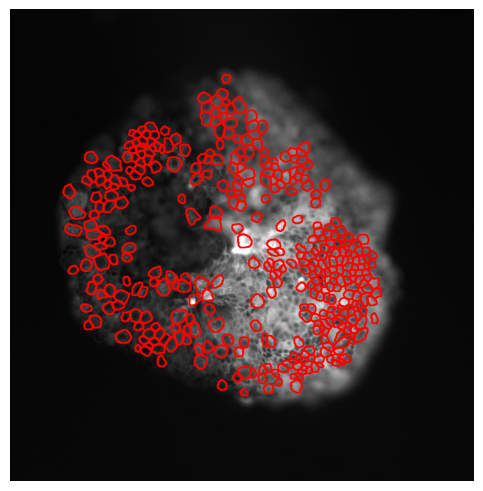

In [551]:
labels = np.unique(pixels_df_after['label'])

# Draw contours

contour_img = cv2.cvtColor(img_after, cv2.COLOR_BGR2GRAY)

for i in labels:
    xs = list(pixels_df_after[pixels_df_after['label']==i]['x'])
    ys = list(pixels_df_after[pixels_df_after['label']==i]['y'])

    mask = np.zeros(contour_img.shape, dtype=int)
    mask[xs,ys]=1
    
    if np.sum(mask) > 0:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(img_after, contours, -1, (255, 0, 0), 2)

fig,ax = plt.subplots(layout='constrained')
ax.imshow(img_after)
bbox_after = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(f'../results/network_characterization_plots/{BOT}/{BOT}_after_segmentation.png', dpi=300, bbox_inches='tight')

### Visualize networks

In [552]:
def plot_edges(ax, mat, com_df, color=(0,0,1,0.6)):
    mat_vals = mat[np.triu_indices(mat.shape[0],k=1)]
    mat_edges_r,mat_edges_c = np.triu_indices(mat.shape[0],k=1)

    for i in range(len(mat_vals)):
        val = mat_vals[i]
        nodei_id = mat_edges_r[i]
        nodej_id = mat_edges_c[i]

        x1 = com_df.iloc[nodei_id]["y"]      
        y1 = com_df.iloc[nodei_id]["x"]      
        
        x2 = com_df.iloc[nodej_id]["y"]      
        y2 = com_df.iloc[nodej_id]["x"]  

        ax.plot([x1,x2],[y1,y2], c=color, linewidth=val)  

In [553]:
NODE_COLOR = 'red'
EDGE_COLOR = (0,0,1,0.6)

Before

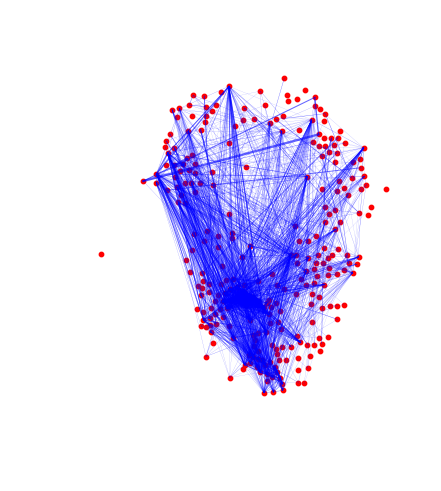

In [554]:
# Plot nodes 

fig,ax = plt.subplots(layout='constrained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_before.shape[0], img_before.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
ax.scatter(com_df_before["y"], com_df_before["x"], c=NODE_COLOR, s=10)
plot_edges(ax, fc_before, com_df_before, color=EDGE_COLOR)

plt.savefig(f'../results/network_characterization_plots/{BOT}/{BOT}_before_network.png', dpi=300, bbox_inches='tight')
plt.show()

After

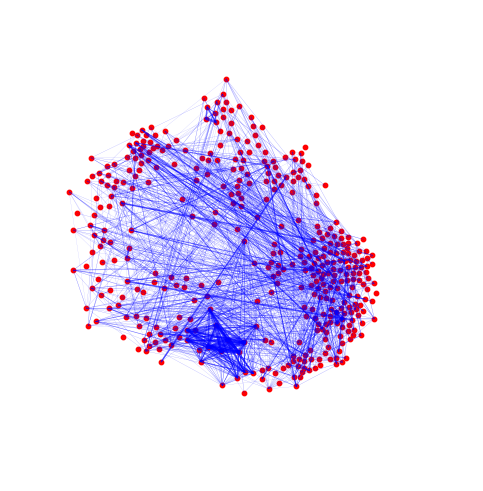

In [555]:
# Plot nodes 

fig,ax = plt.subplots(layout='constrained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_after.shape[0], img_after.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
ax.scatter(com_df_after["y"], com_df_after["x"], c=NODE_COLOR, s=10)
plot_edges(ax, fc_after, com_df_after, color=EDGE_COLOR)

plt.savefig(f'../results/network_characterization_plots/{BOT}/{BOT}_after_network.png', dpi=300, bbox_inches='tight')
plt.show()

### Number of nodes and edges

In [556]:
node_dict = {'before':[],'after':[]}
edge_dict = {'before':[],'after':[]}
BOTS = ['bot_01', 'bot_02', 'bot_03', 'bot_04', 'bot_05', 'bot_06']

for bot in BOTS:

    for phase in ['before','after']:

        fc = np.loadtxt('../network_inference_data/fc_matrices/{}_{}_mimat_w_pruned.csv'.format(bot, phase), delimiter=',')

        nodes = fc.shape[0] 
        edges = np.sum(fc[np.triu_indices(fc.shape[0],k=1)]>0)

        node_dict[phase].append(nodes)
        edge_dict[phase].append(edges)

Nodes

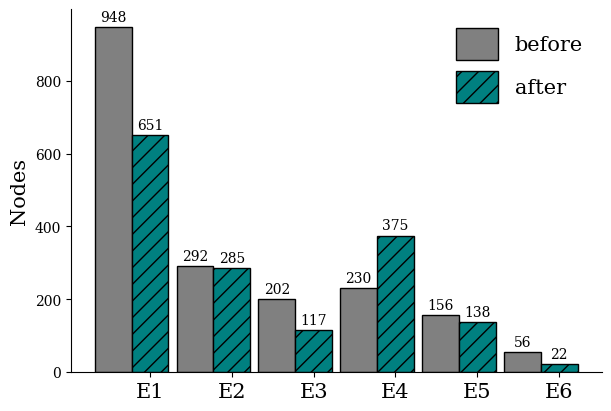

In [557]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')

x = np.arange(len(BOTS))

width = 0.45
multiplier = 0

for label, val in node_dict.items():

    offset = width*multiplier
    # rects = ax.bar(x+offset, val, width, label=label)
    if label =='after':
        rects = ax.bar(x+offset, val, width, label=label, color='teal', edgecolor='k', hatch='//')
    else:
        rects = ax.bar(x+offset, val, width, label=label, color='gray', edgecolor='k')

    ax.bar_label(rects, padding=2)
    multiplier+=1

ax.set_ylabel('Nodes', fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=10)

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

ax.set_xticks(x + width, ['E1','E2','E3','E4','E5','E6'], fontsize=15)
ax.legend(loc='upper right', fontsize=15, frameon=False)

plt.savefig('../results/network_characterization_plots/nodes.png', dpi=300, bbox_inches='tight')


Edges

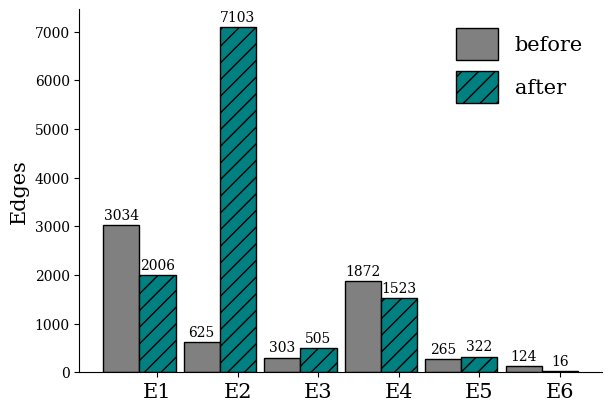

In [558]:
fig, ax = plt.subplots(figsize=(6,4), layout='constrained')

x = np.arange(len(BOTS))

width = 0.45
multiplier = 0

for label, val in edge_dict.items():

    offset = width*multiplier
    # rects = ax.bar(x+offset, val, width, label=label)
    if label =='after':
        rects = ax.bar(x+offset, val, width, label=label, color='teal', edgecolor='k', hatch='//')
    else:
        rects = ax.bar(x+offset, val, width, label=label, color='gray', edgecolor='k')

    ax.bar_label(rects, padding=2)
    multiplier+=1

ax.set_ylabel('Edges', fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=10)

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

ax.set_xticks(x + width, ['E1','E2','E3','E4','E5','E6'], fontsize=15)
ax.legend(loc='upper right', fontsize=15, frameon=False)

plt.savefig('../results/network_characterization_plots/edges.png', dpi=300, bbox_inches='tight')

### Degree Distributions

In [576]:
# Load degree distribution and null distribution
degdist_before = np.loadtxt(f'../network_analysis_data/degree_distributions/{BOT}_before_degree_distribution.csv', delimiter=',')
null_degdist_before = np.loadtxt(f'../network_analysis_data/null_degree_distributions/{BOT}_before.csv', delimiter=',')

degdist_after = np.loadtxt(f'../network_analysis_data/degree_distributions/{BOT}_after_degree_distribution.csv', delimiter=',')
null_degdist_after = np.loadtxt(f'../network_analysis_data/null_degree_distributions/{BOT}_after.csv', delimiter=',')

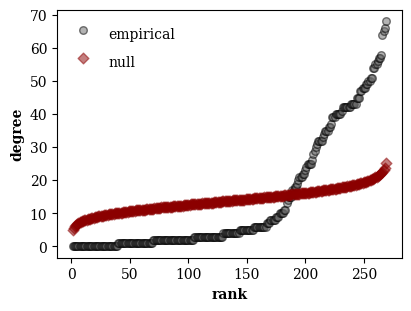

In [560]:
fig, ax = plt.subplots(figsize=(4,3), layout='constrained')

ax.scatter(np.arange(1, len(degdist_before)+1), sorted(degdist_before), s=30, c='dimgray', edgecolors='k', alpha=0.5)
ax.scatter(np.arange(1, len(null_degdist_before)+1), sorted(null_degdist_before), s=30, c='darkred', alpha=0.5, marker='D')

plt.ylabel('degree', fontweight='bold')
plt.xlabel('rank', fontweight='bold')
plt.legend(['empirical', 'null'], frameon=False)
plt.savefig(f'../results/network_characterization_plots/{BOT}/{BOT}_before_degree_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

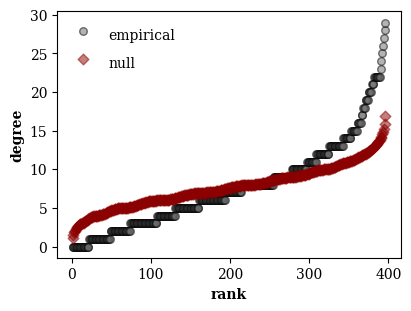

In [561]:
fig, ax = plt.subplots(figsize=(4,3), layout='constrained')

ax.scatter(np.arange(1, len(degdist_after)+1), sorted(degdist_after), s=30, c='dimgray', edgecolors='k',  alpha=0.5)
ax.scatter(np.arange(1, len(null_degdist_after)+1), sorted(null_degdist_after), s=30, c='darkred', alpha=0.5, marker='D')

plt.ylabel('degree', fontweight='bold')
plt.xlabel('rank', fontweight='bold')
plt.legend(['empirical', 'null'], frameon=False)
plt.savefig(f'../results/network_characterization_plots/{BOT}/{BOT}_after_degree_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

Power law

In [577]:
freq_dict_before = dict(Counter(degdist_before))
freq_dict_before_null = dict(Counter(null_degdist_before))

freq_dict_after = dict(Counter(degdist_after))
freq_dict_after_null = dict(Counter(null_degdist_after))

In [578]:
# Before

y_before = np.asarray(list(freq_dict_before.values()))
x_before = np.asarray(list(freq_dict_before.keys()))

log_x_before = np.log10(x_before, where=(x_before!=0))
log_y_before = np.log10(y_before, where=(y_before!=0))

y_before_null = np.asarray(list(freq_dict_before_null.values()))
x_before_null = np.asarray(list(freq_dict_before_null.keys()))

log_x_before_null = np.log10(x_before_null, where=(x_before_null!=0))
log_y_before_null = np.log10(y_before_null, where=(y_before_null!=0))

# After

y_after = np.asarray(list(freq_dict_after.values()))
x_after = np.asarray(list(freq_dict_after.keys()))

log_x_after = np.log10(x_after, where=(x_after!=0))
log_y_after = np.log10(y_after, where=(y_after!=0))

y_after_null = np.asarray(list(freq_dict_after_null.values()))
x_after_null = np.asarray(list(freq_dict_after_null.keys()))

log_x_after_null = np.log10(x_after_null, where=(x_after_null!=0))
log_y_after_null = np.log10(y_after_null, where=(y_after_null!=0))

Before: -0.7457922212380227 2.0964979593343787e-11
Before Null: 0.0 1.0
After: -1.0901391474633357 6.520088300733726e-07
After Null: -0.0032852496319125146 0.7109173477170805


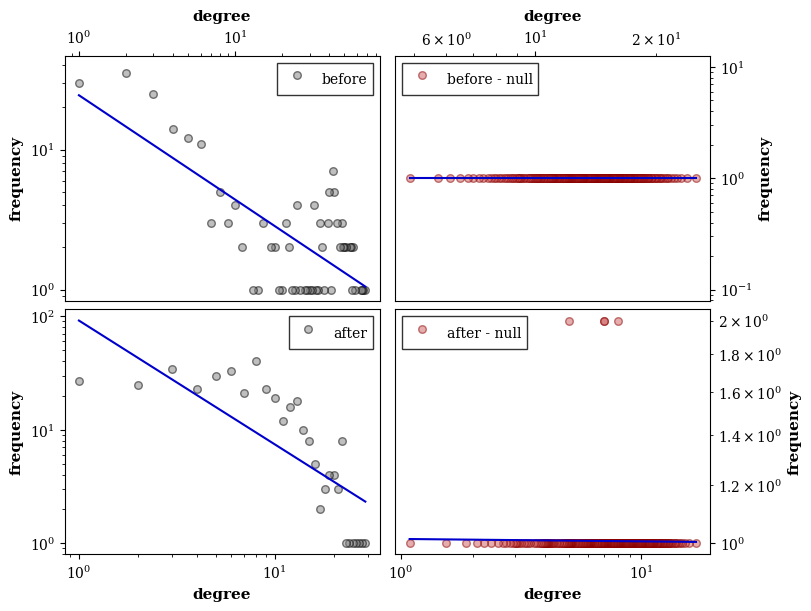

In [579]:
fig, axes = plt.subplots(2,2,figsize=(8,6),layout='constrained')

# Before

axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')

# axes[0,0].invert_yaxis()
axes[0,0].xaxis.tick_top()

axes[0,0].scatter(x_before, y_before, s=30, c='gray', alpha=0.5, edgecolors='k')

m,b,rvalue,pvalue, stderr = linregress(log_x_before, log_y_before)
print('Before:', m, pvalue)

y_pred = b + m*log_x_before

axes[0,0].plot(10**log_x_before, 10**y_pred, 'mediumblue')
axes[0,0].legend(['before'], frameon=True, fancybox=False, edgecolor='k', loc='upper right')

axes[0,0].set_ylabel('frequency', fontsize=11, fontweight='bold')
axes[0,0].set_title('degree', fontsize=11, fontweight='bold')

# Before - null

axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')

axes[0,1].xaxis.tick_top()
axes[0,1].yaxis.tick_right()
axes[0,1].yaxis.set_label_position("right")

axes[0,1].scatter(x_before_null, y_before_null, s=30, c='indianred', alpha=0.5, edgecolors='darkred')

m,b,rvalue,pvalue, stderr = linregress(log_x_before_null, log_y_before_null)
print('Before Null:', m, pvalue)

y_pred = b + m*log_x_before_null

axes[0,1].plot(10**log_x_before_null, 10**y_pred, 'mediumblue')
axes[0,1].legend(['before - null'], frameon=True, fancybox=False, edgecolor='k', loc='upper left')

axes[0,1].set_ylabel('frequency', fontsize=11, fontweight='bold')
axes[0,1].set_title('degree', fontsize=11, fontweight='bold')


# After

axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')

axes[1,0].scatter(x_after, y_after, s=30, c='gray', alpha=0.5, edgecolors='k')

m,b,rvalue,pvalue, stderr = linregress(log_x_after, log_y_after)
print('After:', m, pvalue)

y_pred = b + m*log_x_after

axes[1,0].plot(10**log_x_after, 10**y_pred, 'mediumblue')
axes[1,0].legend(['after'], frameon=True, fancybox=False, edgecolor='k', loc='upper right')

axes[1,0].set_ylabel('frequency', fontsize=11, fontweight='bold')
axes[1,0].set_xlabel('degree', fontsize=11, fontweight='bold')

# After - null

axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log')

axes[1,1].yaxis.tick_right()
axes[1,1].yaxis.set_label_position("right")

axes[1,1].scatter(x_after_null, y_after_null, s=30, c='indianred', alpha=0.5, edgecolors='darkred')

m,b,rvalue,pvalue, stderr = linregress(log_x_after_null, log_y_after_null)
print('After Null:', m, pvalue)

y_pred = b + m*log_x_after_null

axes[1,1].plot(10**log_x_after_null, 10**y_pred, 'mediumblue')
axes[1,1].legend(['after - null'], frameon=True, fancybox=False, edgecolor='k', loc='upper left')

axes[1,1].set_ylabel('frequency', fontsize=11, fontweight='bold')
axes[1,1].set_xlabel('degree', fontsize=11, fontweight='bold')

plt.savefig(f'../results/network_characterization_plots/{BOT}/{BOT}_degree_distribution_powerlaw.png', dpi=300, bbox_inches='tight')
plt.show()

Aggregate Plot

In [565]:
before = {'exp':[],'p':[]}
before_null = {'exp':[],'p':[]}
after = {'exp':[],'p':[]}
after_null = {'exp':[],'p':[]}
BOTS = ['bot_01', 'bot_02', 'bot_03', 'bot_04', 'bot_05', 'bot_06']

for bot in BOTS:

    degdist_before = np.loadtxt(f'../network_analysis_data/degree_distributions/{bot}_before_degree_distribution.csv', delimiter=',')
    null_degdist_before = np.loadtxt(f'../network_analysis_data/null_degree_distributions/{bot}_before.csv', delimiter=',')

    degdist_after = np.loadtxt(f'../network_analysis_data/degree_distributions/{bot}_after_degree_distribution.csv', delimiter=',')
    null_degdist_after = np.loadtxt(f'../network_analysis_data/null_degree_distributions/{bot}_after.csv', delimiter=',')

    freq_dict_before = dict(Counter(degdist_before))
    freq_dict_before_null = dict(Counter(null_degdist_before))

    freq_dict_after = dict(Counter(degdist_after))
    freq_dict_after_null = dict(Counter(null_degdist_after))

    # Before

    y_before = np.asarray(list(freq_dict_before.values()))
    x_before = np.asarray(list(freq_dict_before.keys()))

    log_x_before = np.log10(x_before, where=(x_before!=0))
    log_y_before = np.log10(y_before, where=(y_before!=0))

    y_before_null = np.asarray(list(freq_dict_before_null.values()))
    x_before_null = np.asarray(list(freq_dict_before_null.keys()))

    log_x_before_null = np.log10(x_before_null, where=(x_before_null!=0))
    log_y_before_null = np.log10(y_before_null, where=(y_before_null!=0))

    # After

    y_after = np.asarray(list(freq_dict_after.values()))
    x_after = np.asarray(list(freq_dict_after.keys()))

    log_x_after = np.log10(x_after, where=(x_after!=0))
    log_y_after = np.log10(y_after, where=(y_after!=0))

    y_after_null = np.asarray(list(freq_dict_after_null.values()))
    x_after_null = np.asarray(list(freq_dict_after_null.keys()))

    log_x_after_null = np.log10(x_after_null, where=(x_after_null!=0))
    log_y_after_null = np.log10(y_after_null, where=(y_after_null!=0))

    m,b,rvalue,pvalue, stderr = linregress(log_x_before, log_y_before)
    before['exp'].append(m)
    before['p'].append(pvalue)

    m,b,rvalue,pvalue, stderr = linregress(log_x_before_null, log_y_before_null)
    before_null['exp'].append(m)
    before_null['p'].append(pvalue)

    m,b,rvalue,pvalue, stderr = linregress(log_x_after, log_y_after)
    after['exp'].append(m)
    after['p'].append(pvalue)

    m,b,rvalue,pvalue, stderr = linregress(log_x_after_null, log_y_after_null)
    after_null['exp'].append(m)
    after_null['p'].append(pvalue)

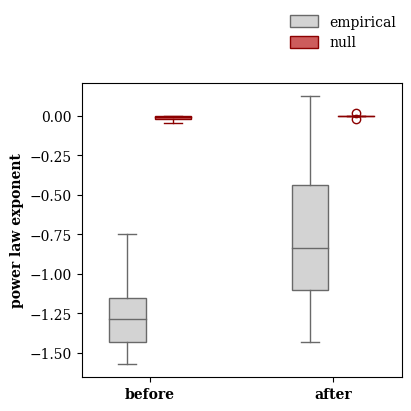

In [572]:
fig, ax = plt.subplots(figsize=(4,4), layout='constrained')

width = 0.2
multiplier = 0

ticks = ['before', 'after']

empirical = [before['exp'], after['exp']]
null = [before_null['exp'], after_null['exp']]

empirical_plot = plt.boxplot(empirical,
                               positions=[1,2], widths=0.2, patch_artist=True)

null_plot = plt.boxplot(null,
                               positions=[1.25,2.25], widths=0.2, patch_artist=True)

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(empirical_plot[item], color='dimgray')
plt.setp(empirical_plot["boxes"], facecolor = 'lightgray')
plt.setp(empirical_plot["fliers"], markeredgecolor='dimgray')

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(null_plot[item], color='darkred')
plt.setp(null_plot["boxes"], facecolor = 'indianred')
plt.setp(null_plot["fliers"], markeredgecolor='darkred')


plt.xticks([1.125,2.125], ticks, fontweight='bold')
plt.xlim([0.75, 2.5])

plt.ylabel('power law exponent', fontweight='bold')


handles = [Patch(facecolor='lightgray', edgecolor='dimgray', label='empirical'), 
           Patch(facecolor='indianred', edgecolor='darkred', label='null')]

ax.legend(handles=handles, handlelength=2, handleheight=1, frameon=False,bbox_to_anchor=(1, 1.25),
                         loc='upper right', borderaxespad=0.)


plt.savefig('../results/network_characterization_plots/powerlaw.png', dpi=300, bbox_inches='tight')
plt.show()